In [124]:
%matplotlib widget

import math
import csv
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import antropy as ant
from sklearn.preprocessing import StandardScaler

In [125]:
begin, end = 1, 61 # (begin is inclusive, end is exclusive)
num_people = 10
count_samples = {
    "active": 8,
    "meditate": 8,
    "neutral": 8
}

class Sample:
    def __init__(self):
        self.data = {
            'RawEEG': [],
            'Alpha': [],
            'Low Beta': [],
            'High Beta': [],
            'Gamma': [],
            'Theta': [],
            'Delta': [],
            'Meditation': [],
            'Attention': []
        }

    def recordDataPoint(self, RawEEG, Attention, Meditation, Alpha, Delta, Theta, LowBeta, HighBeta, Gamma):
        self.data['RawEEG'].append(float(RawEEG))
        self.data['Attention'].append(float(Attention))
        self.data['Meditation'].append(float(Meditation))
        self.data['Alpha'].append(float(Alpha))
        self.data['Delta'].append(float(Delta))
        self.data['Theta'].append(float(Theta))
        self.data['Low Beta'].append(float(LowBeta))
        self.data['High Beta'].append(float(HighBeta))
        self.data['Gamma'].append(float(Gamma))

    '''
    Record a line of data from the CSV output, which takes form RawEEG, Alpha, Delta, Gamma, Low Beta, High Beta, Theta, Attention, Meditation

    '''
    def recordDataLine(self, line):
        self.recordDataPoint(line[0], line[7], line[8], line[1], line[2], line[6], line[4], line[5], line[3])
    
    def getEEG(self):
        return self.data['RawEEG']
    
    def getAttention(self):
        return self.data["Attention"]
    
    def getMeditation(self):
        return self.data["Meditation"]
    
    def getAlpha(self):
        return self.data["Alpha"]
    
    def getDelta(self):
        return self.data["Delta"]
    
    def getTheta(self):
        return self.data["Theta"]
    
    def getLowBeta(self):
        return self.data["Low Beta"]
    
    def getHighBeta(self):
        return self.data["High Beta"]
    
    def getGamma(self):
        return self.data["Gamma"]

    def get(self, key):
        return self.data[key]

In [126]:
data = []
dataLabels = []

def transcribeFileToSample(personN: int, sampleN: int, state: str):
    sample_data = Sample()

    with open("data/all_data/" + state + "_" + str(personN) + "_" + str(sampleN) + ".csv") as f:
        reader = csv.reader(f)

        header = next(reader)
        
        for row in reader:
            sample_data.recordDataLine(row)

        for key in sample_data.data:
            sample_data.data[key] = sample_data.data[key][begin:end]

        data.append(sample_data)
        dataLabels.append(state)

for person in range(num_people):
    for state in count_samples:
        for i in range(count_samples[state]):
            transcribeFileToSample(person + 1, i + 1, state)

In [127]:
dataExtracted = []

def safety_check(x):
    if math.isnan(x): return 0
    if math.isinf(x): return 99999999999
    return x

for point in data:
    extractedPoint = []

    for key in ['RawEEG', 'Alpha', 'Delta', 'Theta', 'Low Beta', 'High Beta', 'Gamma']:
        for func in [np.mean, np.std, ant.sample_entropy, ant.petrosian_fd]:
            extractedPoint.append(safety_check(func(point.get(key))))

    extractedPoint.append(safety_check(ant.spectral_entropy(point.getEEG(), sf=1)))
    
    dataExtracted.append(extractedPoint)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/antropy/entropy.py:249: RuntimeWarning: divide by zero encountered in log2
  se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/antropy/entropy.py:249: RuntimeWarning: invalid value encountered in multiply
  se = -(psd_norm * np.log2(psd_norm)).sum(axis=axis)


In [128]:
x = dataExtracted
y = dataLabels

n_PCA_comps = 15

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

pca = PCA(n_components = n_PCA_comps)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

forestclassifier = RandomForestClassifier(n_estimators=800)
forestclassifier.fit(x_train, y_train)

RandomForestClassifier(n_estimators=800)

In [129]:
transformed_all_data = pca.transform(sc.transform(dataExtracted))

principalDf = pd.DataFrame(data = transformed_all_data, columns = ['PCA' + str(i+1) for i in range(n_PCA_comps)])
labelsDf = pd.DataFrame(data = dataLabels, columns = ['target'])

df = pd.concat((principalDf, labelsDf), axis = 1)

for col in ['PCA' + str(i+1) for i in range(n_PCA_comps)]:
    df[col] = df[col].astype(float)
    df = df[np.abs(df[col]) < 10]

In [130]:
print(classification_report(y_test, forestclassifier.predict(x_test)))
print(forestclassifier.score(x_test, y_test))

              precision    recall  f1-score   support

      active       0.38      0.35      0.36        17
    meditate       0.41      0.50      0.45        14
     neutral       0.53      0.47      0.50        17

    accuracy                           0.44        48
   macro avg       0.44      0.44      0.44        48
weighted avg       0.44      0.44      0.44        48

0.4375


0.9638726289898539


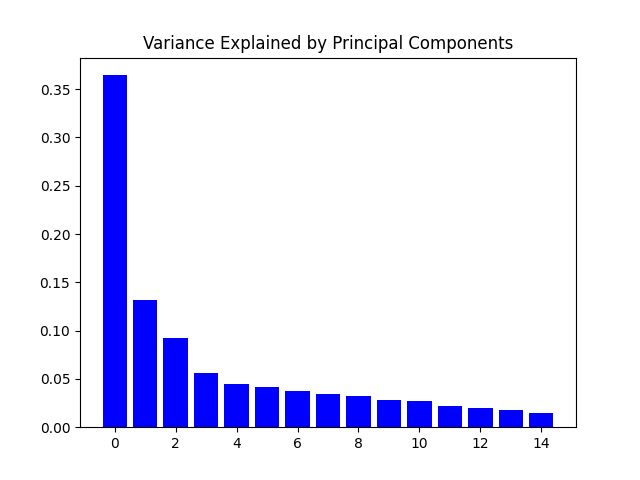

In [131]:
plt.figure()
plt.title("Variance Explained by Principal Components")
plt.bar(range(n_PCA_comps), pca.explained_variance_ratio_, color = 'blue')
print(sum(pca.explained_variance_ratio_))

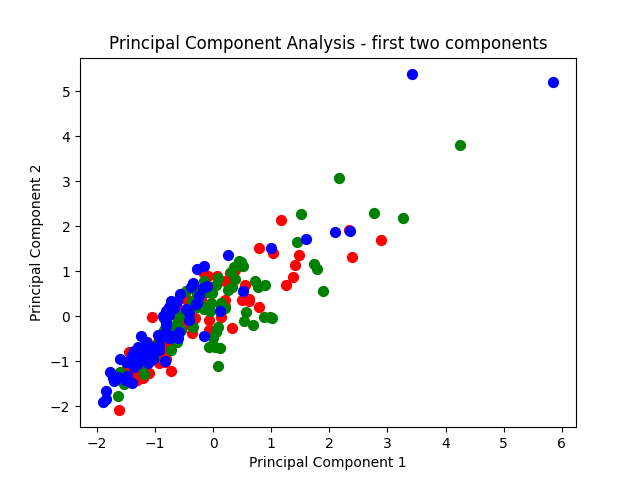

In [132]:
fig = plt.figure()
plt.title("Principal Component Analysis - first two components")
targets = ['active', 'neutral', 'meditate']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['target'] == target
    plt.scatter(df.loc[indicesToKeep, 'PCA1']
               , df.loc[indicesToKeep, 'PCA2']
               , c = color
               , s = 50)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

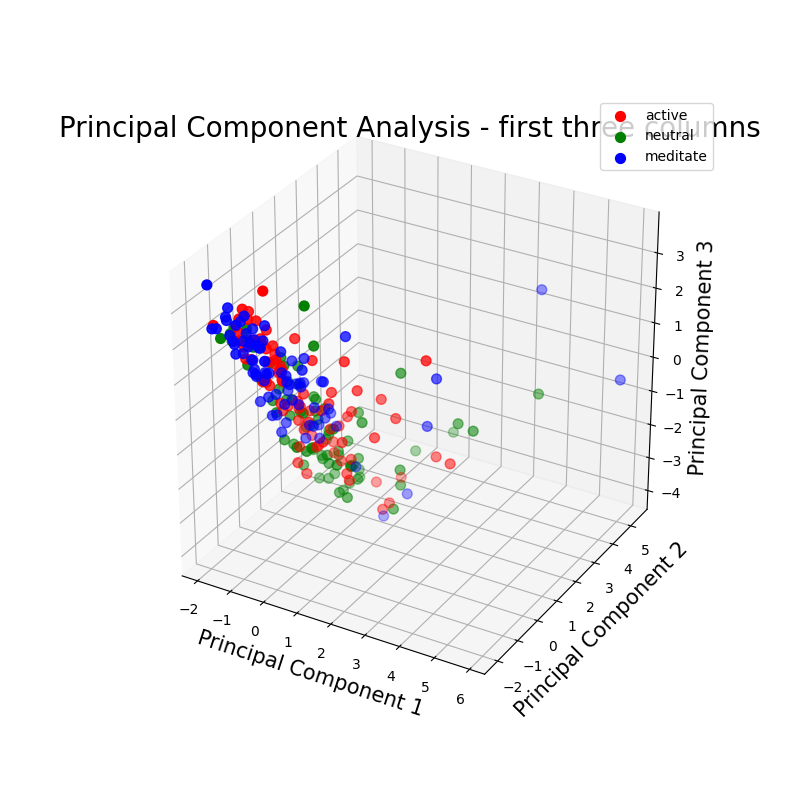

In [133]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d') 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('Principal Component Analysis - first three columns', fontsize = 20)
targets = ['active', 'neutral', 'meditate']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = df['target'] == target
    ax.scatter(df.loc[indicesToKeep, 'PCA1']
               , df.loc[indicesToKeep, 'PCA2']
               , df.loc[indicesToKeep, 'PCA3']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()